In [1]:
cd fastText_multilingual-master

/Users/christanasescu/fastText_multilingual-master


In [2]:
import numpy as np
#import FastVector

In [3]:
import scipy

In [4]:
import pybind11

In [5]:
class FastVector:
    """
    Minimal wrapper for fastvector embeddings.
    ```
    Usage:
        $ model = FastVector(vector_file='/path/to/wiki.en.vec')
        $ 'apple' in model
        > TRUE
        $ model['apple'].shape
        > (300,)
    ```
    """

    def __init__(self, vector_file='', transform=None):
        """Read in word vectors in fasttext format"""
        self.word2id = {}

        # Captures word order, for export() and translate methods
        self.id2word = []

        print('reading word vectors from %s' % vector_file)
        with open(vector_file, 'r') as f:
            (self.n_words, self.n_dim) = \
                (int(x) for x in f.readline().rstrip('\n').split(' '))
            self.embed = np.zeros((self.n_words, self.n_dim))
            for i, line in enumerate(f):
                elems = line.rstrip('\n').split(' ')
                self.word2id[elems[0]] = i
                self.embed[i] = elems[1:self.n_dim+1]
                self.id2word.append(elems[0])
        
        # Used in translate_inverted_softmax()
        self.softmax_denominators = None
        
        if transform is not None:
            print('Applying transformation to embedding')
            self.apply_transform(transform)

    def apply_transform(self, transform):
        """
        Apply the given transformation to the vector space
        Right-multiplies given transform with embeddings E:
            E = E * transform
        Transform can either be a string with a filename to a
        text file containing a ndarray (compat. with np.loadtxt)
        or a numpy ndarray.
        """
        transmat = np.loadtxt(transform) if isinstance(transform, str) else transform
        self.embed = np.matmul(self.embed, transmat)

    def export(self, outpath):
        """
        Transforming a large matrix of WordVectors is expensive. 
        This method lets you write the transformed matrix back to a file for future use
        :param The path to the output file to be written 
        """
        fout = open(outpath, "w")

        # Header takes the guesswork out of loading by recording how many lines, vector dims
        fout.write(str(self.n_words) + " " + str(self.n_dim) + "\n")
        for token in self.id2word:
            vector_components = ["%.6f" % number for number in self[token]]
            vector_as_string = " ".join(vector_components)

            out_line = token + " " + vector_as_string + "\n"
            fout.write(out_line)

        fout.close()

    def translate_nearest_neighbour(self, source_vector):
        """Obtain translation of source_vector using nearest neighbour retrieval"""
        similarity_vector = np.matmul(FastVector.normalised(self.embed), source_vector)
        target_id = np.argmax(similarity_vector)
        return self.id2word[target_id]

    def translate_inverted_softmax(self, source_vector, source_space, nsamples,
                                   beta=10., batch_size=100, recalculate=True):
        """
        Obtain translation of source_vector using sampled inverted softmax retrieval
        with inverse temperature beta.
        nsamples vectors are drawn from source_space in batches of batch_size
        to calculate the inverted softmax denominators.
        Denominators from previous call are reused if recalculate=False. This saves
        time if multiple words are translated from the same source language.
        """
        embed_normalised = FastVector.normalised(self.embed)
        # calculate contributions to softmax denominators in batches
        # to save memory
        if self.softmax_denominators is None or recalculate is True:
            self.softmax_denominators = np.zeros(self.embed.shape[0])
            while nsamples > 0:
                # get batch of randomly sampled vectors from source space
                sample_vectors = source_space.get_samples(min(nsamples, batch_size))
                # calculate cosine similarities between sampled vectors and
                # all vectors in the target space
                sample_similarities = \
                    np.matmul(embed_normalised,
                              FastVector.normalised(sample_vectors).transpose())
                # accumulate contribution to denominators
                self.softmax_denominators \
                    += np.sum(np.exp(beta * sample_similarities), axis=1)
                nsamples -= batch_size
        # cosine similarities between source_vector and all target vectors
        similarity_vector = np.matmul(embed_normalised,
                                      source_vector/np.linalg.norm(source_vector))
        # exponentiate and normalise with denominators to obtain inverted softmax
        softmax_scores = np.exp(beta * similarity_vector) / \
                         self.softmax_denominators
        # pick highest score as translation
        target_id = np.argmax(softmax_scores)
        return self.id2word[target_id]

    def get_samples(self, nsamples):
        """Return a matrix of nsamples randomly sampled vectors from embed"""
        sample_ids = np.random.choice(self.embed.shape[0], nsamples, replace=False)
        return self.embed[sample_ids]

    @classmethod
    def normalised(cls, mat, axis=-1, order=2):
        """Utility function to normalise the rows of a numpy array."""
        norm = np.linalg.norm(
            mat, axis=axis, ord=order, keepdims=True)
        norm[norm == 0] = 1
        return mat / norm
    
    @classmethod
    def cosine_similarity(cls, vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
            (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

    def __contains__(self, key):
        return key in self.word2id

    def __getitem__(self, key):
        return self.embed[self.word2id[key]]

In [6]:
#import numpy as np
#from fasttext import FastVector

# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

# We create dictionaries for both languages based off of the FastText Wiki vectors for each language: 

In [7]:

ro_dictionary = FastVector(vector_file='cc.ro.300.vec')
en_dictionary = FastVector(vector_file='wiki.en.vec')

reading word vectors from cc.ro.300.vec
reading word vectors from wiki.en.vec


# We create a bilingual dictionary based on overlappings between the two languages:

In [8]:
ro_words = set(ro_dictionary.word2id.keys())
en_words = set(en_dictionary.word2id.keys())
overlap = list(en_words & ro_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

In [9]:
# form the training matrices
source_matrix, target_matrix = make_training_matrices(
    ro_dictionary, en_dictionary, bilingual_dictionary)

# We align the RO dictionary with the EN one:

In [10]:
# learn and apply the transformation
transform = learn_transformation(source_matrix, target_matrix)
ro_dictionary.apply_transform(transform)

In [11]:
ro_words = set(ro_dictionary.word2id.keys())

In [12]:

import re
import numpy as np
import pandas as pd
from pprint import pprint
from nltk.tokenize import sent_tokenize, word_tokenize
import os
#The OS module in Python provides a way of using operating system dependent functionality. 
#The functions that the OS module provides allows you to interface with the underlying operating system 
#that Python is running on – be that Windows, Mac or Linux.

from os import listdir
from os.path import isfile, join

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [13]:
import nltk as nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christanasescu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#stopwords = nltk.corpus.stopwords.words("stopwords_Latin.txt")

In [14]:
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = _pre_clean(tokens)
    tokens = [token for token in tokens if len(token) > 0]
    tokens = [token for token in tokens if token not in stopwords]
    #tokens = [get_lemma(token) for token in tokens]
    return tokens

In [15]:
def _pre_clean(list_of_text):
        '''
        preliminary cleaning of the text
        - remove new line character i.e. \n or \r
        - remove tabs i.e. \t
        - remove extra spaces
        '''
        cleaned_list = []
        for text in list_of_text:
            # print("original:", text)
            text = text.replace('\\n', ' ')
            text = text.replace('\\r', ' ')
            text = text.replace('\\t', ' ')
            pattern = re.compile(r'\s+')
            text = re.sub(pattern, ' ', text)
            text = text.strip()
            text = text.lower()
            # check for empty strings
            if text != '' and text is not None:
                cleaned_list.append(text)

        return cleaned_list

In [16]:

stopwords = nltk.corpus.stopwords.words('stop_words_poetry.txt')

stopwords.append('...')
stopwords.append("'d")
stopwords.append('...')
stopwords.append("&")
stopwords.append("upon")
stopwords.append("also")
stopwords.append("hath")
stopwords.append("must")
stopwords.append("therefore")
stopwords.append("doth")
stopwords.append("could")
stopwords.append("would")
stopwords.append("another")
stopwords.append("much")
#stopwords.append("give")
stopwords.append("like")
stopwords.append("since")
#stopwords.append("many")
stopwords.append("without")
#stopwords.append("first")
stopwords.append("though")
#stopwords.append("well")
stopwords.append("often")
#stopwords.append("great")
stopwords.append("either")
stopwords.append("even")
stopwords.append("shall")
#stopwords.append("they")
stopwords.append("what")
stopwords.append("their")
#stopwords.append("more")
#stopwords.append("there")
#stopwords.append("your")
stopwords.append("them")

In [17]:
stopwords.extend(['a', 'like', 'you', 'they', 'he', 'be', 'it', 'your', 'her', 'of', 'more', 'there', 'no', 'not', '’', 'what', 'my', 'his', 'she', 'to', 'our', 'me', 'we', 'in', 'can', 'us', 'an', 'if', 'do', 'this', '”', 'because', 'who', 'hand', 'but', 'him'])

In [15]:
cd fastText_multilingual-master

/Users/christanasescu/fastText_multilingual-master


In [162]:
cd ..

/Users/christanasescu/fastText_multilingual-master


# We open, label, and tokenize all EN poems:

In [18]:
HOME = os.getcwd()

TEXTS_DIR = HOME + "/various_wanted_en/"

filelabels_en = {}

texts_data = []

files = [f for f in os.listdir(TEXTS_DIR) if os.path.isfile(os.path.join(TEXTS_DIR, f))]

import string
from string import punctuation

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))

tokens_total = []

count = -1
 
os.chdir(TEXTS_DIR)
    
for f in files:
    #os.chdir(TEXTS_DIR)
    with open(f, "r", encoding='utf-8', errors = 'ignore') as openf:
        tokens = []
        count = count + 1
        filelabels_en[count] = os.path.basename(openf.name)
        for line in openf:
            sent_text = nltk.sent_tokenize(line)
            for sentence in sent_text:
                tokens1 = tokenize(sentence)
                tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1]
                #filter_object = filter(lambda x: x != "", tokens1)
                tokens1 = [x for x in tokens1 if x!= ""]
                tokens1 = [x.lower() for x in tokens1]
                for token in tokens1:
                    tokens.append(token)
                    tokens_total.append(token)
                #if random.random() > .99:
                #print(tokens)
    #print(tokens_total)
    texts_data.append(tokens)

print(filelabels_en)

{0: '0_note_on_translation.txt', 1: '10_pro_eminescu.txt', 2: '11_stifling_wringing.txt', 3: '12_half_horror_half_joy.txt', 4: '13_empty_problem_full.txt', 5: '14_fret_away.txt', 6: '15_lecture_spirits.txt', 7: '16_facets_overarching.txt', 8: '17_obnoxious_incompetent.txt', 9: '18_always_up_half_full.txt', 10: '19_corpus_expansion_dj.txt', 11: '1_note_on_form.txt', 12: '20_endless_complexity_fun.txt', 13: '21_translated_labor_of_love.txt', 14: '22_scuba_diving_in_the_ass_poetry.txt', 15: '23_violence_or_violins.txt', 16: '2_ecolalia.txt', 17: '3_poetique_curieuse.txt', 18: '4_misery_played.txt', 19: '5_sitting_in_theater.txt', 20: '6_thats_not_poetry.txt', 21: '7_99_isnt_100.txt', 22: '8_parallels_intersect.txt', 23: '9_us_cultural_imperialism.txt'}


In [19]:
filelabels1 = list(filelabels_en)

In [ ]:

#pwd

In [20]:
for i in range(len(filelabels1)):
    texts_data[i] = [x for x in texts_data[i] if x not in stopwords]

In [ ]:
#vect_en = []

In [21]:
def l2_norm(x):
   return np.sqrt(np.sum(x**2))

def div_norm(x):
   norm_value = l2_norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x

In [ ]:
# WE HAVE TO CONVERT EN_WORDS & FR_WORDS TO LISTS (BEFORE RUNNING THE CELLS BELOW) otherwise the code below is not reliable

In [22]:
en_words = list(en_words)
ro_words = list(ro_words)

In [ ]:

# Just checking, you don't have to run this one, might jam up your notebook (it's a lot to print out)
for j in range(len(texts_data[1])):
    if texts_data[1][j] in en_words:
        print(div_norm(la_dictionary[texts_data[1][j]]))
    else:
        continue

# We generate vectors for all EN poems:

In [23]:
vect_en = []

for i in range(len(filelabels1)):
        vect1 = []
        for j in range(len(texts_data[i])):
            if texts_data[i][j] in en_words:
                vect1.append(div_norm(en_dictionary[texts_data[i][j]]))
            else:
                continue
        vect0 = sum(vect1) / len(texts_data[i])
        vect_en.append(vect0)

In [24]:

len(vect_en)

24

In [ ]:
#print(vect_en[21])

In [24]:

cd ..

/Users/christanasescu/fastText_multilingual-master


In [24]:

HOME = os.getcwd()

In [ ]:
pwd

# We move on to the RO subcorpus:

In [25]:

TEXTS_DIR = HOME + "/google_search_ro/"

In [26]:

stopwords = nltk.corpus.stopwords.words("romanian_1.txt")

In [156]:
len(filelabels1)

24

In [27]:
filelabels_ro = {}

texts_data = []

files = [f for f in os.listdir(TEXTS_DIR) if os.path.isfile(os.path.join(TEXTS_DIR, f))]

import string
from string import punctuation

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))

tokens_total = []

count = len(filelabels1) - 1
 
os.chdir(TEXTS_DIR)
    
for f in files:
    #os.chdir(TEXTS_DIR)
    if count <= 300:
        with open(f, "r", encoding='utf-8', errors = 'ignore') as openf:
            tokens = []
            count = count + 1
            filelabels_ro[count] = os.path.basename(openf.name)
            for line in openf:
                sent_text = nltk.sent_tokenize(line)
                for sentence in sent_text:
                    tokens1 = tokenize(sentence)
                    tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1]
                #filter_object = filter(lambda x: x != "", tokens1)
                    tokens1 = [x for x in tokens1 if x!= ""]
                    for token in tokens1:
                        tokens.append(token)
                        tokens_total.append(token)
                #if random.random() > .99:
                #print(tokens)
    #print(tokens_total)
        texts_data.append(tokens)

print(filelabels_ro)

{24: '0_liceu_poezie_pandemie_razvan_chiorean.txt', 25: '1_infatisarea_diavolului_lucia_terzea_ofrim.txt', 26: '2_reciclarea_pe_intelesul_copiilor.txt', 27: '3_poezie_saracie_pandemie_galaicu-paun.txt', 28: '4_reciclare_creativa.txt', 29: '5_cluj_spoken_word.txt', 30: '6_sedinta_parlament_post-pandemie.txt', 31: '7_adevarul_ro.txt', 32: '8_olivia_ignatescu_director_stirbey.txt', 33: '9_varia.txt', 34: 'varia_1.txt', 35: 'varia_10.txt', 36: 'varia_11.txt', 37: 'varia_12.txt', 38: 'varia_13.txt', 39: 'varia_14.txt', 40: 'varia_2.txt', 41: 'varia_3.txt', 42: 'varia_4.txt', 43: 'varia_5.txt', 44: 'varia_6.txt', 45: 'varia_7.txt', 46: 'varia_8.txt', 47: 'varia_9.txt'}


In [33]:
len(texts_data)

24

In [28]:

filelabels2 = list(filelabels_ro)

In [29]:

for i in range(24):
    texts_data[i] = [x for x in texts_data[i] if x not in stopwords]

# We generate vectors representing every single RO poem:

In [30]:
vect_ro = []

for i in range(24):
        vect1 = []
        for j in range(len(texts_data[i])):
            if texts_data[i][j] in ro_words:
                vect1.append(div_norm(ro_dictionary[texts_data[i][j]]))
            else:
                continue
        vect0 = sum(vect1) / len(texts_data[i])
        vect_ro.append(vect0)

In [37]:

len(vect_ro)

24

# We consolidate EN and RO vectors into one single list:

In [31]:

vect_total = [*vect_en, *vect_ro]

In [32]:

len(vect_total)

48

In [ ]:
# We create a list of all labels as well, EN & FR together:

In [33]:

#labels = filelabels1 + filelabels2

labels = [*filelabels1, *filelabels2]

In [41]:
len(labels)

48

In [34]:

dt = [('correlation', float)]

In [35]:

vect_mat = np.mat(vect_total)

# We calculate the matrix of similiarities between all vectors, EN & RO. Then we generate the network representing that matrix: the nodes are all EN & RO poem-vectors and the edges represent the similarities between every two nodes:

In [36]:

similarity_matrix = np.matrix((vect_mat * vect_mat.T).A, dtype=dt)

In [37]:

import networkx as nx

G = nx.from_numpy_matrix(similarity_matrix)

weights = [(G[tpl[0]][tpl[1]]['correlation']) for tpl in G.edges()]

In [38]:

e = [(x, x) for x in G.nodes()] 
G.remove_edges_from(e)

In [39]:
def draw_graph(G):
    weights = [(G[tpl[0]][tpl[1]]['correlation']) for tpl in G.edges()]
    normalized_weights = [400*weight/sum(weights) for weight in weights]
    fig, ax = plt.subplots(figsize=(25, 16))
    pos=nx.spring_layout(G)
    labels1 = dict([x for x in enumerate(labels)])
    #labels=labels
    nx.draw_networkx(
        G,
        pos,
        edges=G.edges(),
        width=normalized_weights,
        labels=labels1,
        with_labels=True,
        node_size=800,
        node_color='r',
        alpha=1,
        font_color = 'w',
        font_size=20
    )
    #plt.show()
    return

In [40]:
import matplotlib.pyplot as plt

/Users/christanasescu/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


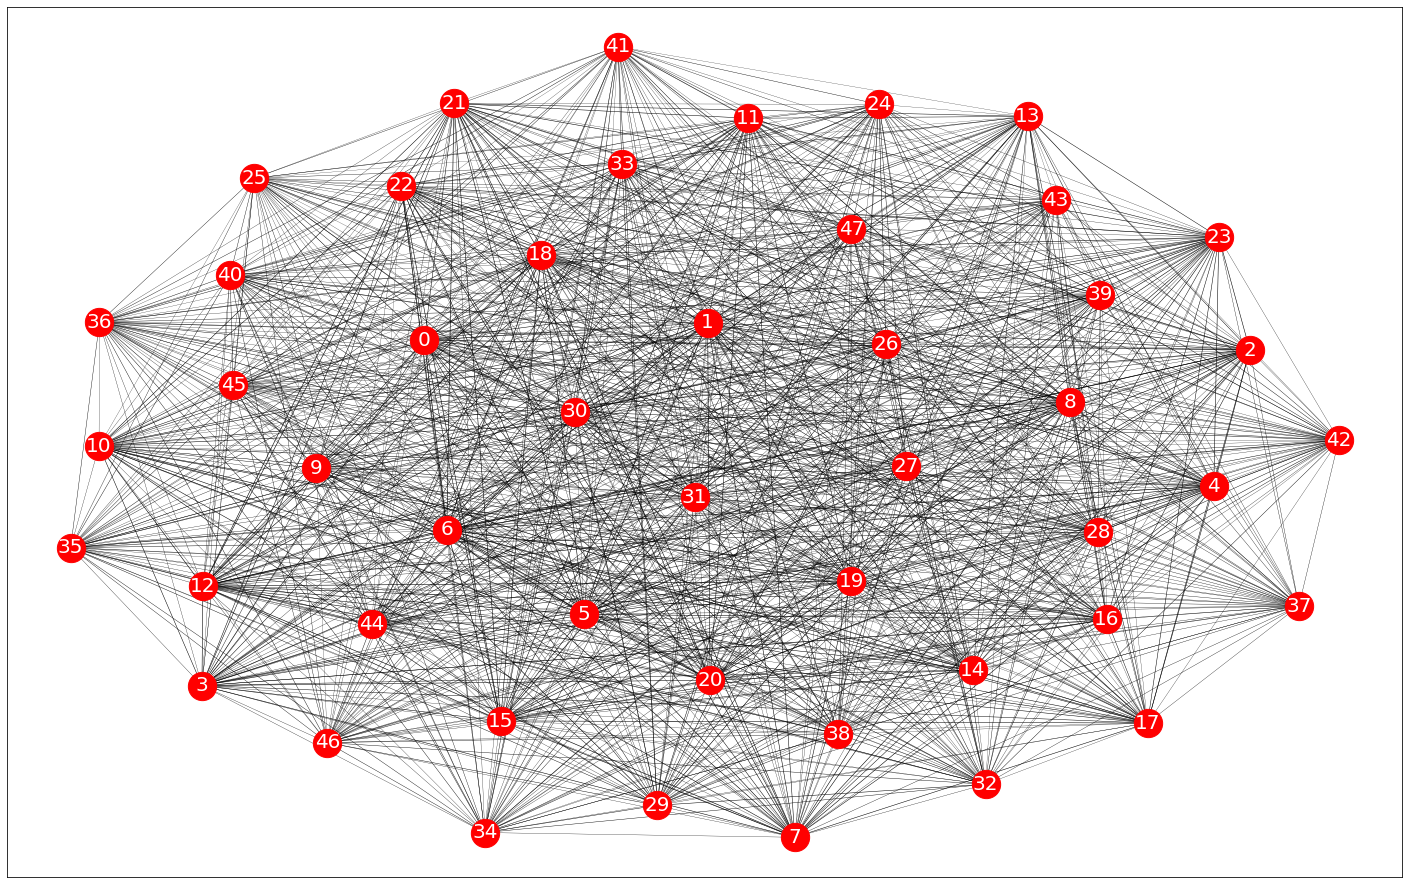

In [41]:
draw_graph(G) # Here is our bilingual corpus

# This is our bilingual English and Romanian corpus; the nodes are the poems represented as correlated vectors based off of the wiki multilingual word embeddings that we aligned in FastText. 

In [50]:

len(list(G.nodes))

48

In [42]:

len(list(G.edges))

1128

In [43]:

weights = [(tpl,(G[tpl[0]][tpl[1]]['correlation'])) for tpl in G.edges()]

# We sort the edges in the decreasing order of similarities between the poem-nodes they connect:

In [44]:

Sorted_weights = sorted(weights, key = lambda t: t[1], reverse = True)

In [45]:
print(Sorted_weights[0]) # the strongest correlation

((6, 12), 0.21708419795530215)


In [46]:

print(Sorted_weights[(len(Sorted_weights)-1)]) # the weakest correlation

((13, 45), 0.06499300525775512)


In [ ]:

#VECTORS AND FILE LABELS NEED BE SWITCED TO EN & RO

In [47]:

filelabels_en[6]

'15_lecture_spirits.txt'

In [58]:

filelabels_en[12]

'20_endless_complexity_fun.txt'

In [59]:

filelabels_en[13]

'21_translated_labor_of_love.txt'

In [60]:

filelabels_ro[45]

'varia_7.txt'

In [48]:

filelabels_total = {}

In [49]:
filelabels_total.update(filelabels_en)

In [50]:
filelabels_total.update(filelabels_ro)

In [51]:

Degrees = G.degree(weight = "correlation")
Sorted_degrees = sorted(Degrees, key = lambda t: t[1], reverse = True)

In [52]:

Sorted_degrees[0] #node with the highest degree

(12, 6.518037678277401)

In [66]:
Sorted_degrees[len(Sorted_degrees)-1] #node with the lowest degree

(43, 4.663134084034551)

In [75]:

#print(filelabels_total)

In [53]:
print(Sorted_degrees)

[(12, 6.518037678277401), (6, 6.4722572357234585), (7, 6.211558792084722), (5, 6.190792639073944), (8, 6.173275811947153), (20, 6.126741963583177), (2, 6.112299653610365), (23, 6.066488328356549), (15, 6.052878165284985), (3, 6.004175003354955), (21, 5.973859466389833), (18, 5.952405094260877), (10, 5.867820731774052), (4, 5.858295564596471), (19, 5.821598117917489), (1, 5.808798884524446), (11, 5.743556333979991), (22, 5.724032385171123), (17, 5.659273094316978), (29, 5.630063151930699), (0, 5.623675170153931), (14, 5.573056685898634), (28, 5.503897190346193), (16, 5.452760399705794), (26, 5.433901107152528), (13, 5.317599455147012), (33, 5.264970245311718), (30, 5.261124514031606), (32, 5.255745903407413), (42, 5.192715462837345), (36, 5.17889524249538), (34, 5.146184178825444), (24, 5.141967832939134), (46, 5.118154281140218), (35, 5.108408032072521), (44, 5.076896136731863), (40, 5.07328026725733), (38, 4.949168727622719), (37, 4.941208468575343), (27, 4.932484891192959), (39, 4.91

In [54]:

clo_cen = nx.closeness_centrality(G)
import operator
c = sorted(clo_cen.items(), key=operator.itemgetter(1), reverse=True)
print("Closeness centralities for G:", c)

Closeness centralities for G: [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0), (25, 1.0), (26, 1.0), (27, 1.0), (28, 1.0), (29, 1.0), (30, 1.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0)]


In [70]:
# Weighted Closeness Centrality:
clo_cen_w = nx.closeness_centrality(G, distance = 'correlation')
c_w = sorted(clo_cen_w.items(), key=operator.itemgetter(1), reverse=True)
print("Weighted closeness centralities for G in decreasing order", c_w)

Weighted closeness centralities for G in decreasing order [(43, 10.079058237016325), (47, 10.07188904260835), (25, 10.06127980842803), (45, 9.97772833747967), (31, 9.852689350189582), (41, 9.77704311308027), (9, 9.592582049185985), (39, 9.560674608376932), (27, 9.536718903507097), (37, 9.515435568147048), (38, 9.50401488566843), (44, 9.38050666299365), (40, 9.318334912266971), (13, 9.28908440411802), (35, 9.20687508179049), (30, 9.179781643008571), (32, 9.174933374971655), (16, 9.173404355967472), (24, 9.161016641019833), (46, 9.15930961739123), (34, 9.139717719828349), (42, 9.08348640809356), (36, 9.083033552965658), (22, 9.022104355922446), (33, 8.936992025912069), (26, 8.843762438332734), (4, 8.719408961109625), (0, 8.687045189308174), (10, 8.685095316102403), (1, 8.62366928099352), (18, 8.61005678174558), (19, 8.595938916487533), (28, 8.58530734987858), (11, 8.570036353500054), (14, 8.56032534684016), (17, 8.559861248278938), (15, 8.54300703999237), (21, 8.466721952024024), (5, 8.4

In [71]:
#Betweeness centrality
bet_cen = nx.betweenness_centrality(G, weight = "correlation")
bet = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)
print("Betweenness centralities for G in decreasing order:", bet)

Betweenness centralities for G in decreasing order: [(45, 0.18593894542090658), (41, 0.02220166512488437), (16, 0.01942645698427382), (44, 0.010175763182238668), (13, 0.005550416281221092), (22, 0.0018501387604070306), (0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (14, 0.0), (15, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (42, 0.0), (43, 0.0), (46, 0.0), (47, 0.0)]


In [72]:
#Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G, weight = "correlation")
eigenvector = sorted(eigenvector_centrality.items(), key=operator.itemgetter(1), reverse=True)
print("Eigenvector centralities for G in decreasing order:", eigenvector)

Eigenvector centralities for G in decreasing order: [(12, 0.17436923434759055), (6, 0.17356516326519994), (7, 0.16623684344781223), (5, 0.1661378156199092), (8, 0.16449812098200864), (20, 0.16397141579015315), (2, 0.16373296823222014), (15, 0.16266821585453153), (23, 0.1624603120095704), (21, 0.16025795034162618), (3, 0.16022445515374356), (18, 0.15987258916761685), (10, 0.15765360498071657), (4, 0.1575348371057125), (19, 0.15629854745559696), (1, 0.15599035718704932), (22, 0.1543175697490334), (11, 0.15263408851654145), (17, 0.1517544618067747), (0, 0.15097283434833314), (14, 0.1490744859468935), (16, 0.1469761736397058), (13, 0.14318356052152056), (29, 0.1431365187284923), (28, 0.1402511835347314), (26, 0.1376016219399266), (33, 0.13425429860294294), (30, 0.13296138320862988), (42, 0.13215714156294245), (36, 0.1320908339899389), (46, 0.13156735423664326), (32, 0.13149344616476602), (34, 0.1314857188292962), (9, 0.13146856745849658), (35, 0.13085599892618668), (24, 0.1308295491482456)

In [ ]:

#dag_longest_path(G, weight = "correlation")

In [ ]:

# len(filelabels_total)

In [116]:
# len(filelabels_en)

200

In [117]:
# len(filelabels_ro)

100

In [73]:

filelabels_ro

{24: '0_liceu_poezie_pandemie_razvan_chiorean.txt',
 25: '1_infatisarea_diavolului_lucia_terzea_ofrim.txt',
 26: '2_reciclarea_pe_intelesul_copiilor.txt',
 27: '3_poezie_saracie_pandemie_galaicu-paun.txt',
 28: '4_reciclare_creativa.txt',
 29: '5_cluj_spoken_word.txt',
 30: '6_sedinta_parlament_post-pandemie.txt',
 31: '7_adevarul_ro.txt',
 32: '8_olivia_ignatescu_director_stirbey.txt',
 33: '9_varia.txt',
 34: 'varia_1.txt',
 35: 'varia_10.txt',
 36: 'varia_11.txt',
 37: 'varia_12.txt',
 38: 'varia_13.txt',
 39: 'varia_14.txt',
 40: 'varia_2.txt',
 41: 'varia_3.txt',
 42: 'varia_4.txt',
 43: 'varia_5.txt',
 44: 'varia_6.txt',
 45: 'varia_7.txt',
 46: 'varia_8.txt',
 47: 'varia_9.txt'}

In [74]:
# filelabels_total

In [55]:

E = list(G.edges)

In [56]:

weights_list = [(e, (G[e[0]][e[1]]['correlation'])) for e in E]

# We are trying to find a route that would alternate between EN & RO poems in the decreasing order of similarity (i.e., weight of connecting edges) without crossing the same node (i.e., poem) twice:

Here are all the edges connecting EN to RO poems:

In [57]:

weights_en_to_ro = [(e, (G[e[0]][e[1]]['correlation'])) for e in E if e[0] in filelabels_en and e[1] in filelabels_ro]

In [78]:

weights_en_to_ro[0]

((0, 24), 0.08288229269489139)

In [58]:

len(weights_en_to_ro)

576

In [59]:

Sorted_weights_en_to_ro = sorted(weights_en_to_ro, key = lambda t: t[1], reverse = True)

In [60]:

Sorted_weights_en_to_ro[0] # The strongest EN-RO correlation

((12, 37), 0.11284105119199725)

In [82]:
filelabels_total[12]

'20_endless_complexity_fun.txt'

In [83]:
filelabels_total[37]

'varia_12.txt'

In [61]:

List_poem_itinerary = []

In [62]:



List_poem_itinerary.extend([(12, filelabels_total[12]), (37, filelabels_total[37])])

In [94]:

len(List_poem_itinerary)

2

In [87]:
weights_to_en_37 = [e for e in Sorted_weights_en_to_ro if e[0][1]==37]

In [88]:
weights_to_en_37

[((12, 37), 0.11284105119199722),
 ((6, 37), 0.11259609683557116),
 ((2, 37), 0.11176960148133713),
 ((8, 37), 0.1112101514105864),
 ((7, 37), 0.1097952179648855),
 ((5, 37), 0.10888560560206482),
 ((23, 37), 0.10875010996307072),
 ((3, 37), 0.10872039150443566),
 ((20, 37), 0.10761382825072613),
 ((15, 37), 0.10557450355303238),
 ((21, 37), 0.10476477830154432),
 ((10, 37), 0.10443883240584742),
 ((4, 37), 0.10443082992050134),
 ((18, 37), 0.10434055231875444),
 ((19, 37), 0.10284377944341225),
 ((1, 37), 0.10246060538210933),
 ((0, 37), 0.10088891571603491),
 ((14, 37), 0.1000740013931431),
 ((11, 37), 0.0999514973923439),
 ((17, 37), 0.09855434616803732),
 ((22, 37), 0.09789787807996825),
 ((16, 37), 0.09608938467669882),
 ((13, 37), 0.09498012935948244),
 ((9, 37), 0.08764235860902034)]

# Let us identify the poem-nodes on such a route and the order in which they need to be crossed:

In [63]:

List_poem_itinerary = []
List_poem_itinerary.extend([(12, filelabels_total[12]), (37, filelabels_total[37])])

i = List_poem_itinerary[(len(List_poem_itinerary) - 1)][0]

while len(List_poem_itinerary) <= len(filelabels_total):
    if i < 24:
        weights_to_ro = []
        weights_to_ro = [e for e in Sorted_weights_en_to_ro if e[0][0]==i]
        for j in range(1, len(weights_to_ro)):
            if (weights_to_ro[j][0][1], filelabels_total[weights_to_ro[j][0][1]]) not in List_poem_itinerary:
                List_poem_itinerary.append((weights_to_ro[j][0][1], filelabels_total[weights_to_ro[j][0][1]]))
                i = weights_to_ro[j][0][1]
                break
        else:
            break
    else:
        weights_to_en = []
        weights_to_en = [e for e in Sorted_weights_en_to_ro if e[0][1]==i]
        for k in range(1, len(weights_to_en)): 
            if (weights_to_en[k][0][0], filelabels_total[weights_to_en[k][0][0]]) not in List_poem_itinerary:
                List_poem_itinerary.append((weights_to_en[k][0][0], filelabels_total[weights_to_en[k][0][0]]))
                i = weights_to_en[k][0][0]
                break
        else:
            break

# This is our EN-RO alternating route:

In [64]:
print(List_poem_itinerary)

[(12, '20_endless_complexity_fun.txt'), (37, 'varia_12.txt'), (6, '15_lecture_spirits.txt'), (29, '5_cluj_spoken_word.txt'), (8, '17_obnoxious_incompetent.txt'), (32, '8_olivia_ignatescu_director_stirbey.txt'), (7, '16_facets_overarching.txt'), (28, '4_reciclare_creativa.txt'), (3, '12_half_horror_half_joy.txt'), (46, 'varia_8.txt'), (20, '6_thats_not_poetry.txt'), (35, 'varia_10.txt'), (2, '11_stifling_wringing.txt'), (34, 'varia_1.txt'), (23, '9_us_cultural_imperialism.txt'), (33, '9_varia.txt'), (5, '14_fret_away.txt'), (42, 'varia_4.txt'), (11, '1_note_on_form.txt'), (36, 'varia_11.txt'), (21, '7_99_isnt_100.txt'), (38, 'varia_13.txt'), (14, '22_scuba_diving_in_the_ass_poetry.txt'), (26, '2_reciclarea_pe_intelesul_copiilor.txt'), (17, '3_poetique_curieuse.txt'), (39, 'varia_14.txt'), (18, '4_misery_played.txt'), (47, 'varia_9.txt'), (15, '23_violence_or_violins.txt'), (24, '0_liceu_poezie_pandemie_razvan_chiorean.txt'), (0, '0_note_on_translation.txt'), (27, '3_poezie_saracie_pande

In [91]:
len(List_poem_itinerary)

48

In [66]:
Itinerary_names = []

In [67]:
for i in range(len(List_poem_itinerary)):
    Itinerary_names.append(List_poem_itinerary[i][1])

In [96]:
print(Itinerary_names)

['20_endless_complexity_fun.txt', 'varia_12.txt', '15_lecture_spirits.txt', '5_cluj_spoken_word.txt', '17_obnoxious_incompetent.txt', '8_olivia_ignatescu_director_stirbey.txt', '16_facets_overarching.txt', '4_reciclare_creativa.txt', '12_half_horror_half_joy.txt', 'varia_8.txt', '6_thats_not_poetry.txt', 'varia_10.txt', '11_stifling_wringing.txt', 'varia_1.txt', '9_us_cultural_imperialism.txt', '9_varia.txt', '14_fret_away.txt', 'varia_4.txt', '7_99_isnt_100.txt', 'varia_11.txt', '22_scuba_diving_in_the_ass_poetry.txt', '2_reciclarea_pe_intelesul_copiilor.txt', '3_poetique_curieuse.txt', 'varia_14.txt', '1_note_on_form.txt', '0_liceu_poezie_pandemie_razvan_chiorean.txt', '0_note_on_translation.txt', '3_poezie_saracie_pandemie_galaicu-paun.txt', '10_pro_eminescu.txt', 'varia_9.txt', '23_violence_or_violins.txt', 'varia_13.txt', '5_sitting_in_theater.txt', 'varia_2.txt', '19_corpus_expansion_dj.txt', '6_sedinta_parlament_post-pandemie.txt', '4_misery_played.txt', 'varia_6.txt', '18_alway

# We are looking for a line in each of these poems along our route--stronger to weaker cross-language links, to the least aligned--a line best representing the poem vector-prosody-wise, that is, a line whose vector has the greatest cosine similarity to the vector of the poem as a whole

Let's start with an example and then generalize to the whole itinerary:

In [ ]:

Oceano = ['Les particules d’eau se collent à la peau', 'regorgent d’abstraction', 'Cette sensation de fluidité intrinsèque à chaque atome', 'perpètre la cénesthésie créative des neuf premiers mois', 'L’imaginaire se berce dans la pensée', 'se concentre sur la caresse du geste répété', 'se laisse flotter comme un objet éloigné de tout', 'C’est ainsi que je survis', 'sur une île de bonheur submergée par les ondes', 'Je regarde le monde à travers ce voile', 'le seul que je peux supporter', 'je constate sa beauté et mon indifférence', 'ses couleurs se font de plus en plus intenses', 'mes yeux sont aveuglés par la tendre tempête', 'J’ai enfin appris à nager']

In [ ]:
texts_tokens = []

for y in Oceano:
    #os.chdir(TEXTS_DIR)
    #with open(f, "r", encoding='utf-8', errors = 'ignore') as openf:
        tokens = []
        #count = count + 1
        #filelabels_fr[count] = os.path.basename(openf.name)
        #for line in y:
            #sent_text = nltk.sent_tokenize(line)
        
        tokens1 = tokenize(y)
        tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1]
                #filter_object = filter(lambda x: x != "", tokens1)
        tokens1 = [x for x in tokens1 if x!= ""]
        for token in tokens1:
                    tokens.append(token)
                    #tokens_total.append(token)
                #if random.random() > .99:
                #print(tokens)
    #print(tokens_total)
        texts_tokens.append(tokens)

In [ ]:

for i in range(len(texts_tokens)):
    texts_tokens[i] = [x for x in texts_tokens[i] if x not in stopwords]

In [ ]:

len(texts_tokens)

In [ ]:

print(texts_tokens)

In [ ]:

vect_oceano = []

for i in range(len(texts_tokens)):
        vect1 = []
        for j in range(len(texts_tokens[i])):
            if texts_tokens[i][j] in fr_words:
                vect1.append(div_norm(fr_dictionary[texts_tokens[i][j]]))
            else:
                continue
        vect0 = sum(vect1) / len(texts_tokens[i])
        vect_oceano.append(vect0)

In [ ]:

# from numpy import dot
# from numpy.linalg import norm

In [ ]:
# We compute cosine similarity between all the [vectors of the] lines making up the poem [vect_oceano] 
# and the overall poem they belong in [oceanotherapie_sybille_rembard.txt / node no. 400]

cos_list = []

for i in range(len(vect_oceano)):
    cos_sim = 0
    cos_sim = dot(vect_oceano[i], vect_total[400])/(norm(vect_oceano[i])*norm(vect_total[400]))
    cos_list.append((i, cos_sim))

In [ ]:

print(cos_list)

In [ ]:

sorted_cos_list = sorted(cos_list, key = lambda t: t[1], reverse = True)

In [ ]:

sorted_cos_list[0]

In [ ]:
# Here is the line that best represents the poem in terms of vector prosody
print(Oceano[6])

In [94]:
pwd

'/Users/christanasescu/fastText_multilingual-master/google_search_ro'

In [95]:

cd ..

/Users/christanasescu/fastText_multilingual-master


In [60]:
cd cannes_en_fr

/Users/christanasescu/fastText_multilingual-master/cannes_en_fr


In [ ]:
HOME = os.getcwd()

In [81]:

pwd

'/Users/christanasescu/fastText_multilingual-master/cannes_en_fr'

In [82]:
cd ..

/Users/christanasescu/fastText_multilingual-master


# We need to move all--and only--the poems on our route into a new directory. We start with the EN ones and then do the same with the RO poems on the route.

In this case it is actually all the poems in both folders.

In [68]:
import shutil 
import os 
import logging

In [69]:
pwd

'/Users/christanasescu/fastText_multilingual-master/google_search_ro'

In [70]:
cd ..

/Users/christanasescu/fastText_multilingual-master


In [71]:
HOME = os.getcwd()

In [72]:
source = HOME + "/various_wanted_en/"

In [73]:
destination = HOME + "/two_walls_and_a_mirror_en_&_ro_itinerary/"

In [74]:
files = os.listdir(source)

In [75]:
for f in files:
    if f in Itinerary_names:
        shutil.move(source+f, destination)

Now the RO ones:

In [76]:

source = HOME + "/google_search_ro/"

In [77]:
files = os.listdir(source)

In [78]:
for f in files:
    if f in Itinerary_names:
        shutil.move(source+f, destination)

# Now that we got all the poems needed into one directory, we convert each of them into a list of lines (in which every element is a line in that specific poem) and consolidate these lists into a list of lists whose order of elements is the one of the destinations on our route:

In [105]:

HOME = os.getcwd()

Poems_Dir = HOME + "/two_walls_and_a_mirror_en_&_ro_itinerary/"
#Poems_Dir = HOME

os.chdir(Poems_Dir)
lines = [i for i in range(len(Itinerary_names))]

for i in range(len(List_poem_itinerary)):
    lines_1 = []
    with open (List_poem_itinerary[i][1], 'rt') as file:
        for line in file:
                line = line.replace('\\n', ' ')
                line = line.replace('\\r', ' ')
                line = line.replace('\\t', ' ')
                pattern = re.compile(r'\s+')
                line = re.sub(pattern, ' ', line)
                line = line.strip()
                line = line.lower()
                # check for empty strings
                if line != '' and line is not None:
                    lines_1.append(line)
        lines[i] = lines_1
    
    
    

        

In [107]:

lines[0]

['the endless complexity',
 'fun and',
 'of not theory',
 'being chaos',
 'one combining',
 'the displacement',
 'band of transcriptions',
 '‘and’ neophloglodyte',
 'and a',
 '‘and’ as',
 'never myself',
 'yielding describing',
 'a sum verse',
 'witnessed idiosyncratic',
 'dozens dancers',
 'of the hands',
 'killings manipulation with',
 'adapting in want of',
 'songs to me',
 'to speak sing',
 'to young to dare',
 'romanians you',
 'everything’s who are',
 'on sale']

In [108]:
List_poem_itinerary[0]

(12, '20_endless_complexity_fun.txt')

In [80]:
poems_tokens = []

In [81]:

for line in lines:
    poems_tokens.append(line)

# Or poems_tokens.extend(lines)

In [90]:

import copy

#poems_tokens = copy.copy(lines)

In [82]:

# Let's make sure they are not one and the same object:

poems_tokens is lines

False

In [83]:
lines[1]

['forum liber - întrebați și discutați cu romania orice',
 'our lord and savior lenghel, imi place sa mananc, compune poezii despre ... / load of medical equipment to help tunisia fight the covid pandemic',
 'poezie la metafizică experimentală / drd. ... de reciclare a hârtiei şi cartonului / drd',
 'la uvt, - revista orizont http://www.revistaorizont.ro › arhiva › august2021 pdf',
 'scheletele poeziei, aşa că nu vă voi da în ... / adunat textele puse acolo în vreme de pandemie într-un volum al cărui titlu are']


We tokenize the lines of each poem separately and thus convert the lines into lists of tokens:

In [84]:

for i in range(len(lines)):
    for j in range(len(lines[i])):
        tokens = []
        tokens1 = tokenize(lines[i][j])
        tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1 if item != "/"]
        tokens1 = [x for x in tokens1 if x!= ""]
        for token in tokens1:
                    tokens.append(token)
        poems_tokens[i][j] = tokens


In [123]:

poems_tokens[0]

[['the', 'endless', 'complexity'],
 ['fun', 'and'],
 ['of', 'not', 'theory'],
 ['being', 'chaos'],
 ['one', 'combining'],
 ['the', 'displacement'],
 ['band', 'of', 'transcriptions'],
 ['‘', 'and', '’', 'neophloglodyte'],
 ['and'],
 ['‘', 'and', '’'],
 ['never', 'myself'],
 ['yielding', 'describing'],
 ['sum', 'verse'],
 ['witnessed', 'idiosyncratic'],
 ['dozens', 'dancers'],
 ['of', 'the', 'hands'],
 ['killings', 'manipulation', 'with'],
 ['adapting', 'want', 'of'],
 ['songs', 'to', 'me'],
 ['to', 'speak', 'sing'],
 ['to', 'young', 'to', 'dare'],
 ['romanians', 'you'],
 ['everything', '’', 's', 'who'],
 ['on']]

In [85]:

stopwords_0 = nltk.corpus.stopwords.words('stop_words_poetry.txt')

In [86]:

for i in range(len(poems_tokens)):
    if i % 2 == 0:
        for j in range(len(poems_tokens[i])):
            poems_tokens[i][j] = [x for x in poems_tokens[i][j] if x not in stopwords_0]
    else:
        for j in range(len(poems_tokens[i])):
            poems_tokens[i][j] = [x for x in poems_tokens[i][j] if x not in stopwords]

In [126]:
poems_tokens[0]

[['endless', 'complexity'],
 ['fun'],
 ['not', 'theory'],
 ['being', 'chaos'],
 ['one', 'combining'],
 ['displacement'],
 ['band', 'transcriptions'],
 ['‘', '’', 'neophloglodyte'],
 [],
 ['‘', '’'],
 ['never', 'myself'],
 ['yielding', 'describing'],
 ['sum', 'verse'],
 ['witnessed', 'idiosyncratic'],
 ['dozens', 'dancers'],
 ['hands'],
 ['killings', 'manipulation'],
 ['adapting', 'want'],
 ['songs', 'me'],
 ['speak', 'sing'],
 ['young', 'dare'],
 ['romanians', 'you'],
 ['everything', '’', 'who'],
 []]

In [126]:
len(poems_tokens)

201

In [ ]:
#poems_tokens[1]

In [87]:

for poem in poems_tokens:
    for k in poem:
        if k == []:
            poem.remove(k)
        else:
            if len(k) == 0:
                poem.remove(k)

In [88]:
for i in range(len(poems_tokens)):
    if len(poems_tokens[i]) == 0:
        print(i)

In [233]:
# Don't need to run this one if the one above worked

for i in range(len(poems_tokens)):
    if len(poems_tokens[i]) == 0:
        poems_tokens.remove(poems_tokens[i])
    else:   
        for j in range(len(poems_tokens[i])):
            if len(poems_tokens[i][j]) == 0:
                poems_tokens[i].remove(poems_tokens[i][j])

IndexError: list index out of range

In [93]:

from numpy import dot
from numpy.linalg import norm

In [94]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# We compute vectors for every single line in every single poem:

In [91]:
vectors_of_lines1 = copy.copy(lines)

for i in range(len(poems_tokens)):
    vectors_of_lines1[i] = []
    if i % 2 == 0:
        for j in range(len(poems_tokens[i])):
            vect1 = []
            for k in range(len(poems_tokens[i][j])):
                    if poems_tokens[i][j][k] in en_words:
                        vect1.append(div_norm(en_dictionary[poems_tokens[i][j][k]]))
                    else:
                        continue
            if len(poems_tokens[i][j]) != 0:
                vect0 = sum(vect1) / len(poems_tokens[i][j])
            else:
                vect0 = 0
            vectors_of_lines1[i].append((j, vect0))
    else:
        for j in range(len(poems_tokens[i])):
            vect1 = []
            for k in range(len(poems_tokens[i][j])):
                    if poems_tokens[i][j][k] in ro_words:
                        vect1.append(div_norm(ro_dictionary[poems_tokens[i][j][k]]))
                    else:
                        continue
            if len(poems_tokens[i][j]) != 0:
                vect0 = sum(vect1) / len(poems_tokens[i][j])
            else:
                vect0 = 0
            vectors_of_lines1[i].append((j, vect0))

In [132]:
vectors_of_lines1[0]

[(0,
  array([-0.03248679,  0.01785793, -0.032975  ,  0.09213828,  0.01332061,
          0.01537307,  0.06917934, -0.04752053, -0.04304378,  0.0470044 ,
          0.02024159,  0.05141778, -0.05300349,  0.00482419,  0.08524649,
         -0.03945555, -0.00984833,  0.04625124,  0.03139426,  0.03449438,
         -0.03975703,  0.02394017,  0.00658163, -0.00160334, -0.0164738 ,
         -0.05918258, -0.02330944,  0.04996803,  0.01107019, -0.00820521,
         -0.0662719 ,  0.12184793,  0.01513002,  0.05802348,  0.04164937,
          0.0236322 , -0.0043119 , -0.01213972, -0.02400234,  0.02478173,
          0.02599198,  0.01602059, -0.0023992 , -0.00206391,  0.00185664,
          0.03101267,  0.02867574, -0.01728435,  0.02418436, -0.00775859,
          0.00032973, -0.01864431,  0.00945852, -0.05815052,  0.01541358,
          0.06020496,  0.05211294,  0.02819207, -0.0111924 , -0.01182093,
          0.01317398, -0.01801609,  0.10585826, -0.03047811,  0.0085095 ,
         -0.03038931,  0.03578213

In [236]:
for i in range(len(vectors_of_lines1)):
    if len(vectors_of_lines1[i]) != len(lines[i]):
        print(i, len(vectors_of_lines1[i]), len(lines[i]))

1 2 3
9 26 27
22 197 308
36 29 30
57 209 213
59 22 23
75 148 155
77 23 24
88 5 6
121 307 322
124 23 29
128 35 36
134 86 100
138 454 466
162 380 381
165 44 45
170 68 69
183 90 91
186 19 21
188 20 21
190 103 106
199 69 79


In [162]:
lines[1]

['au revoir', 'en quel lieu', 'que ce soit']

In [163]:
vectors_of_lines1[1]

[(0,
  array([-0.06027117,  0.01835834, -0.11999991, -0.0418566 , -0.11930101,
         -0.03534057, -0.01786638, -0.01486834, -0.0701061 ,  0.01913453,
          0.02080312, -0.05288971, -0.18415523, -0.1272166 ,  0.0150404 ,
         -0.04492373,  0.01180301,  0.03310161,  0.03332704, -0.01185187,
          0.03293341,  0.0861828 , -0.04872225, -0.02700895, -0.02009912,
          0.07118934, -0.01124426,  0.00824872,  0.03831173, -0.00581993,
         -0.11753123,  0.06926211,  0.01035831, -0.02471023,  0.00530876,
          0.01631328, -0.00758955, -0.04100157, -0.15826374, -0.05056697,
         -0.0318545 , -0.00647311,  0.01425601,  0.0023809 , -0.00722679,
          0.00848223,  0.07009429,  0.03659073,  0.03558002,  0.05060957,
          0.09215554, -0.16189747,  0.07535788, -0.02325712, -0.03974207,
          0.05145682, -0.05211936,  0.02979607,  0.03892987,  0.00909617,
         -0.05592192, -0.02875123,  0.02912926,  0.12019328, -0.0879969 ,
         -0.06148496,  0.06390957

# We compute cosine similarity between [the vector of] every line in a poem and [the vector of] that specific poem. Every poem will now be represented by a list of line numbers and values of [line and poem] cosine similarity:

In [95]:
cos_list_total = copy.copy(vectors_of_lines1)

for i in range(len(vectors_of_lines1)):
    cos_list = []
    #sorted_cos_list = []
    for j in range(len(vectors_of_lines1[i])):
        cos_sim = 0
        cos_sim = dot(vectors_of_lines1[i][j][1], vect_total[List_poem_itinerary[i][0]])/(norm(vectors_of_lines1[i][j][1])*norm(vect_total[List_poem_itinerary[i][0]]))
        cos_list.append((j, cos_sim))
    cos_list_total[i] = cos_list

In [96]:
print(cos_list_total)

[[(0, 0.6540113019320306), (1, 0.5554042968399152), (2, 0.60790761700504), (3, 0.6689294744517241), (4, 0.6746989760040729), (5, 0.37666505877968426), (6, 0.5816852037998081), (7, 0.47852447912640605), (8, 0.47852447912640583), (9, 0.6492542994433756), (10, 0.6233044934982568), (11, 0.6230375097169144), (12, 0.6795134315125017), (13, 0.6178189356365226), (14, 0.4822967351952808), (15, 0.611693209116381), (16, 0.6914884242514544), (17, 0.6619321859588461), (18, 0.5900405161310585), (19, 0.5839608486771733), (20, 0.6277026614672789), (21, 0.6762187083011694)], [(0, 0.651345413160768), (1, 0.8237201481250539), (2, 0.6540375155754977), (3, 0.5792843660686547), (4, 0.7555090375970975)], [(0, 0.37999115911866616), (1, 0.4261561218441563), (2, 0.8524328912479171), (3, 0.8636224843315375), (4, 0.7367704854141646), (5, 0.6970040171390174), (6, 0.39328019888085325), (7, 0.6031541551930627), (8, 0.6411609917909665), (9, 0.5570028115138487), (10, 0.46998085098714054), (11, 0.536632271630874), (12,

In [97]:
cos_list_total1 = copy.copy(cos_list_total)

for i in range(len(cos_list_total1)):
    for j in range(len(cos_list_total1[i])):
        if type(cos_list_total1[i][j][1]) == np.ndarray:
            cos_list_total1[i][j] = (j, 0)

In [98]:
print(cos_list_total1)

[[(0, 0.6540113019320306), (1, 0.5554042968399152), (2, 0.60790761700504), (3, 0.6689294744517241), (4, 0.6746989760040729), (5, 0.37666505877968426), (6, 0.5816852037998081), (7, 0.47852447912640605), (8, 0.47852447912640583), (9, 0.6492542994433756), (10, 0.6233044934982568), (11, 0.6230375097169144), (12, 0.6795134315125017), (13, 0.6178189356365226), (14, 0.4822967351952808), (15, 0.611693209116381), (16, 0.6914884242514544), (17, 0.6619321859588461), (18, 0.5900405161310585), (19, 0.5839608486771733), (20, 0.6277026614672789), (21, 0.6762187083011694)], [(0, 0.651345413160768), (1, 0.8237201481250539), (2, 0.6540375155754977), (3, 0.5792843660686547), (4, 0.7555090375970975)], [(0, 0.37999115911866616), (1, 0.4261561218441563), (2, 0.8524328912479171), (3, 0.8636224843315375), (4, 0.7367704854141646), (5, 0.6970040171390174), (6, 0.39328019888085325), (7, 0.6031541551930627), (8, 0.6411609917909665), (9, 0.5570028115138487), (10, 0.46998085098714054), (11, 0.536632271630874), (12,

# We sort the cosine similarity lists representing the poems and keep only the maximum value and the number of the line whose cosine similarity to the poem it belongs in is maximum. Every poem on our route will be now represented by a tuple consisting of the line number and the cosine similarity value:

In [99]:
cos_max = []
cos_sorted = list(range(len(cos_list_total1)))

for i in range(len(cos_list_total1)):
    cos_sorted[i] = sorted(cos_list_total1[i], key = lambda t: t[1], reverse = True)
    cos_max.append(cos_sorted[i][0])

In [100]:
cos_max[0]

(16, 0.6914884242514544)

In [101]:
cos_max[1]

(1, 0.8237201481250539)

# Our "Bilingual Corpus Journey Poem" will include from each poem on the EN-RO itinerary the line with the maximum cosine similarity:

In [106]:

Bilingual_Corpus_Journey_Poem = []

for i in range(len(lines)):
    k = cos_max[i][0]
    Bilingual_Corpus_Journey_Poem.append(lines[i][k])

In [142]:


len(Bilingual_Corpus_Journey_Poem)

48

In [107]:

print(Bilingual_Corpus_Journey_Poem, sep = "\n")

['killings manipulation with', 'our lord and savior lenghel, imi place sa mananc, compune poezii despre ... / load of medical equipment to help tunisia fight the covid pandemic', 'damning that in rock music one cannot lie', 'pandemie contra poezie ... / dar scriitorii clujeni au reuşit să scoată / tot ce e mai bun din această / perioadă şi să se inspire / pentru noi poezii', 'democracy inside the brain simple elision of less familiar references', 'în acest termen relativ scurt, am acumulat un bagaj bogat de cunoștințe, am căpătat deprinderi noi,', 'knowledge and experience his entire face lit. i love', 'acțiunile practice de colectare a deșeurilor de echipamente electrice și electronice s-au îmbinat fericit cu diverse alte forme de activitate: jocuri și plimbări, activități artistice (poezii, desene, filme', 'the cat, not curiosity of it against the white', 'scoasă deîndată din clişeu; ponciful e reciclat, i se redeschide cursul, ... / pandemiei, cât și ulterior, în toate ... recitat p

Here is our 

# Bilingual Corpus Journey Poem "Two Walls and a Mirror" (EN-RO)

In [108]:

for line_of_verse in Bilingual_Corpus_Journey_Poem:
        print(line_of_verse)

killings manipulation with
our lord and savior lenghel, imi place sa mananc, compune poezii despre ... / load of medical equipment to help tunisia fight the covid pandemic
damning that in rock music one cannot lie
pandemie contra poezie ... / dar scriitorii clujeni au reuşit să scoată / tot ce e mai bun din această / perioadă şi să se inspire / pentru noi poezii
democracy inside the brain simple elision of less familiar references
în acest termen relativ scurt, am acumulat un bagaj bogat de cunoștințe, am căpătat deprinderi noi,
knowledge and experience his entire face lit. i love
acțiunile practice de colectare a deșeurilor de echipamente electrice și electronice s-au îmbinat fericit cu diverse alte forme de activitate: jocuri și plimbări, activități artistice (poezii, desene, filme
the cat, not curiosity of it against the white
scoasă deîndată din clişeu; ponciful e reciclat, i se redeschide cursul, ... / pandemiei, cât și ulterior, în toate ... recitat poezii despre apă
there’s more